# Data Wrangling - Assignment 3

This notebook scrapes data from the platform [hikr.org](https://www.hikr.org). To do this it uses persisted HTML files of the website which are stored in a S3 Bucket. For distributed computing the library PySpark is used.

## 0. Setup

As a first step the required libraries are installed and imported. If the notebook is not run on Databricks, set the global variable `LOCAL` to `True`.

In [1]:
LOCAL = False

### 0.1. Install and Import Dependencies

In [2]:
if LOCAL:
    %pip install -r requirements.txt
else:
    %pip install -U dateparser
    %pip install -U matplotlib
    %pip install -U numpy>=1.22.4
    %pip install -U pandas
    %pip install -U PyArrow
    %pip install -U scrapy
    %pip install -U scipy
    %pip install -U seaborn


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Adding libraries with the command above might not always work. The following steps can be taken, if issues arise when installing libraries:

- Go to the "Clusters" panel on the left
- Select your cluster
- Go to the "Libraries" tab
- Click "Install New"
- Choose "PyPI" as library source
- Type the name of the library, "scrapy", into the package field
- Click "Install"
- Wait until the installation has finished

Now the library can be used on Databricks as well.

In [3]:
# Set LOCAL variable again, since the Python interpreter is restarted
# during install
LOCAL = False
import logging
from datetime import datetime
from pathlib import Path
from typing import Dict, List, Tuple, Union

import dateparser
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import seaborn as sns
from parsel import SelectorList
if not LOCAL:
    from pyspark.rdd import PipelinedRDD
    from pyspark.sql.functions import col, when, count
    from pyspark.sql.types import IntegerType, StringType
from scrapy.selector import Selector

### 0.2. Global Variables

The `LOCAL` variable above specifies whether the Notebook is run locally or on Databricks. If it is set to `True`, the Notebook is assumed to be run locally. Therefore, global variables are created for all files and directories used in the local environment.

In [4]:
if LOCAL:
    DATA_DIR = Path().cwd() / "data"
    POSTS_DIR = DATA_DIR / "200posts"
    LOGS_DIR = Path().cwd() / "logs"

### 0.3. Initalize Logger

A logger is used to get debug outputs when working with pyspark.

In [0]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

## 1. Parsing Hikes

The hikes are parsed using the `parse` function and the helper functions defined below. This process yields a set of features for all hikes.

The following features have been extracted:

| Feature | Description | Purpose |
| :--- | :--- | :--- |
| Name | The name of the Tour. | Provides a short description of the tour. |
| Date | The date on which the tour took place. | Provides insights on how old the data of the post is. |
| Peaks | A list of peaks the tour contains. (The number of peaks can range from 0 to n peaks per tour.) | Allows to count tours that contain a peak. | 
| Difficulty Hiking | How difficult the tour is on the hiking scale. See [definition on hiker.org](https://www.hikr.org/post238.html). | Can be used to select tours based on their difficulty. |
| Difficulty Climbing | How difficult the tour is on the climbing scale. See [definition on hiker.org](https://www.hikr.org/post247.html). | Can be used to select tours based on their difficulty. |
| Difficulty Fixed-Rope Tour | How difficult the tour is on the fixed-rope route (Klettersteig). See [definition on hiker.org](https://www.hikr.org/post180345.html). | Can be used to select tours based on their difficulty. |
| Difficulty Skiing | How difficult the tour is on the climbing scale. See [definition on hiker.org](https://www.hikr.org/post249.html). | Can be used to select tours based on their difficulty. |
| Required Time | How long a tour takes to complete. | Can be used to select tours with a certain length. |
| Ascent | How much elevation (in meters) is gained throughout the tour. | Allows to filter tours based on how challenging they are. |
| Number Of Comments | How many comments there are on the hiker.org post. | Can be used to find out how popular a tour is. |

For certain features preprocessing and data cleaning steps were necessary. They are shown in the table below:

| Feature | Preprocessing Steps |
| :--- | :--- |
| Date | 1. The date was converted to a datetime object. To parse the date string the library [dateparser](https://pypi.org/project/dateparser/) was used, which allows to parse month names in multiple languages without having the locales installed. Also, the dateparser library can work with multiple date formats. | 
| Peaks | 1. A regular expression was used to remove the height of the peaks. |
| Difficulties | 1. The actual difficulty levels were extracted using regular expressions. | 
| Required Time | 1. The time string was extracted using a regular expressions. <br> 2. Additional regular expressions were used to extract the number of days hours and minutes. <br> 3. Finally, the time in minutes was calculated. |

### 1.1. Helper Functions for Parsing

All helper functions do not throw an error if a feature is missing in a post. Instead, they return `None` to indicate the the value is not present for this post.

In [0]:
def extract_required_time(document: Selector) -> Union[int, None]:
    """Extract the required time by calculating the time in minutes.
    
    Parameters
    ----------
    document : Selector
        The selector that contains the raw time value.

    Returns
    -------
    int or None
        The required time in minutes. If no time was found ``None`` is
        returned.
    """
    # get the content of the time data cell of the table
    time = document.xpath(
        '//td[text()="Zeitbedarf:"]/following-sibling::td/text()'
    )

    if (len(time) == 0):
        logger.warning(f"No time found: {time}")
        return None
    
    if (time.re_first(r"(?:\d+ Tage? )?(?:(?:[0-1]?[0-9]|2[0-3]):[0-5][0-9])|\d+ Tage?") 
            is not None):
        days = int(time.re_first(r"(\d+) Tage?", default=0))
        hours = int(time.re_first(r"(\d{1,2}):?\d{1,2}", default=0))
        minutes = int(time.re_first(r"\d{1,2}:?(\d{1,2})", default=0))

        return 24*60*days + 60*hours + minutes
    else:
        logger.warning(f"Invalid time format encountered: {time}")
        return None
    

def extract_date(document: Selector) -> Union[datetime, None]:
    """Extract the date of the tour from the ``document``

    Parameters
    ----------
    document : Selector
        The HTML document to extract the date from.

    Returns
    -------
    datetime or None
        The date on which the tour took place. If no date was found
        ``None`` is returned.
    """
    date_string = document.xpath(
        '//td[text()="Tour Datum:"]/following-sibling::td/text()'
    ).get()

    if date_string is None:
        logger.warning("No date found.")
        return None
    
    # use a third party library that allows for more control when
    # parsing dates
    date = dateparser.parse(
        date_string.strip(),
        date_formats=["%d %B %Y"],
        languages=["de", "fr", "it", "en"],
    )

    if date is None:
        logger.warning(f"Invalid date format encountered: {date_string}")

    return date

def extract_peaks(document: Selector) -> List[str]:
    """Extract all peaks of a tour. A tour can contain zero, one or multiple
    peaks.

    Parameters
    ----------
    document : Selector
        The HTML document to extract the peaks from.

    Returns
    -------
    List[str]
        The names of the peaks in the tour.
    """
    peaks_text = document.xpath(
        '//img[contains(@src, "ico2_peak_s.png")]/following-sibling::a/text()'
    )
    peaks = peaks_text.re(r"(.+) (?:-?\d+ m|-?\d+m)")

    if (len(peaks) == 0):
        logger.warning(f"No peaks found. Original text: {peaks_text}")

    return peaks

def extract_ascent(document: Selector) -> Union[int, None]:
    """Extract the ascent in meters.
    
    Parameters
    ----------
    document : Selector
        The HTML document to extract the ascent from.

    Returns
    -------
    int or None
        The ascent in meters.
    """
    ascent_text = document.xpath(
        '//td[contains(text(), "Aufstieg:")]/following-sibling::td/text()'
    )
    ascent = ascent_text.re_first(r"(\d+)\sm")

    if ascent is not None:
        ascent = int(ascent)
    else:
        logger.warning(f"Invalid ascent format encountered: {ascent_text}")
    
    return ascent

In [0]:
def parse(tour: Tuple[str, str]) -> dict:
    """Parse a hikr.org tour and extract all the attributes we are interested
    in.
     
    Parameters
    ----------
    tour : Tuple[str, str]
        HTML Content of the hikr.org tour. The first string is the name
        of the file in which the tour is stored in. The second string
        is the content of the file.
    
    Returns
    -------
    dict
        A dictionary containing the extracted attributes for this tour.
    """
    # id is the filename, text is the file content
    id, text = tour
    # Parse it using scrapy
    document = Selector(text=text)
    
    # Extraction
    result = {
        "id": id, 
        "name": document.css("h1.title::text").get(),
        "date": extract_date(document),
        "peaks": extract_peaks(document),
        "difficulty_hiking": document.xpath(
            '//td[text()="Wandern Schwierigkeit:"]/following-sibling::td/a/text()'
        ).re_first(r"(T[1-6][\+-]?)"),
        "difficulty_climbing": document.xpath(
            '//td[text()="Klettern Schwierigkeit:"]/following-sibling::td/a/text()'
        ).re_first(r"(\w{1,4}[\+-]?)"),
        "difficulty_fixed-rope_route": document.xpath(
            '//td[text()="Klettersteig Schwierigkeit:"]/following-sibling::td/a/text()'
        ).re_first(r"(\w{1,2}[\+-]?)"),
        "difficulty_skiing": document.xpath(
            '//td[text()="Ski Schwierigkeit:"]/following-sibling::td/a/text()'
        ).re_first(r"(\w{1,2}[\+-]?)"),
        "required_time_minutes": extract_required_time(document),
        "ascent_meters": extract_ascent(document),
        "num_comments": len(document.xpath(
            '//table[@id="comment_table"]//td/div[starts-with(@id, "tr_comment_")]/@id'
        ).getall())
    }
    return result

In [0]:
# Extract the 200posts.zip file in the same folder where this jupyter notebook is located.
# Then you can run the parse function on an example tour:
# original file: post24010.html
if LOCAL:
    for post in POSTS_DIR.iterdir():
        with open(post) as f:
            content = f.read()
            r = parse((f.name, content))
            print(r)

INFO:py4j.clientserver:Received command c on object id p0


## 2. Parallelization & Aggregation (Spark)

Here, Apache Spark is used to parallelize the parsing process. This part only works on databricks

**Warning:** In the community edition, databricks terminates your cluster after 2 hours of inactivity. If you re-create the cluster, you will lose your data.

In [0]:
# AWS Access configuration
# Enter keys here:
# sc._jsc.hadoopConfiguration().set()
# sc._jsc.hadoopConfiguration().set()

# Contains the whole hikr dataset.
# The full dataset contains 42330 tours and has a size of around 3 GB. Use this dataset for your final results if possible. 
# Execution is likely to take around 20 to 30 minutes.
# tours = sc.wholeTextFiles("s3a://dawr-hikr3/hikr/*.html")

# There are 8176 posts starting with "post10*", which is a nicer size for smaller experiments. (~ 5 minutes to process)
# tours = sc.wholeTextFiles("s3a://dawr-hikr3/hikr/post10*.html")

# If you want to further shrink the dataset size for testing, you can add another zero (or more) to the pattern (post100*.html).
tours = sc.wholeTextFiles("s3a://dawr-hikr3/hikr/*.html")

INFO:py4j.clientserver:Received command c on object id p0


In [0]:
# Apply our parse function and persist the parse results so that we can repeat all further steps easier
import pyspark
parsedTours = tours.map(parse).persist(pyspark.StorageLevel.MEMORY_AND_DISK)

INFO:py4j.clientserver:Received command c on object id p0


In [0]:
# actually force the parsedTours RDD. Above it was only defined, but not evaluated. This will take a while.
n_tours = parsedTours.count()

In [0]:
n_tours

INFO:py4j.clientserver:Received command c on object id p0


Out[11]: 42330

### 2.1. Filter Tours

In [0]:
def get_hiking_difficulties_below(difficulty: str) -> List[str]:
    """Get all hiking difficulties below ``difficulty``.

    Parameters
    ----------
    difficulty : str    
        The difficulty which all returned difficulties should be
        below.

    Returns
    -------
    List[str]
        A list of all difficulties below ``difficulty``. The 
        value of ``difficulty`` itself is not included.  
    """
    difficulties = [
        "T1-", "T1", "T1+",
        "T2-", "T2", "T2+",
        "T3-", "T3", "T3+",
        "T4-", "T4", "T4+",
        "T5-", "T5", "T5+",
        "T6-", "T6", "T6+",
    ]

    max_index = difficulties.index(difficulty)
    return difficulties[:max_index]


def filter_comments(
    tours: PipelinedRDD,
    min_comments: int,
    max_comments: Union[int, None] = None,
) -> PipelinedRDD:
    """Filter by the number of comments for a tour.

    Parameters
    ----------
    tours : PipelinedRDD
        The tours to filter.
    min_comments : int
        The minimal number of comments that is required (inclusive).
    max_comments : int, optional
        The maximal number of comments that is required (inclusive).
        If max_comments is not given, there is no upper bound.

    Returns
    -------
    PipelinedRDD
        The filtered RDD.
    """

    if max_comments is None:
        filtered = (
            tours
            .filter(lambda t: t["num_comments"] >= min_comments)
        )
    else:
        filtered = (
            tours
            .filter(lambda t: t["num_comments"] >= min_comments
                    and t["num_comments"] <= max_comments)
        )
    return filtered


def filter_only_hiking_tours(tours: PipelinedRDD) -> PipelinedRDD:
    """Remove all tours that have other difficulties then hiking.

    Parameters
    ----------
    tours : PipelinedRDD
        The tours to filter.

    Returns
    -------
    PipelinedRDD
        The filtered RDD.
    """
    return (
        tours
        .filter(
            lambda t: t["difficulty_climbing"] is None
            and t["difficulty_fixed-rope_route"] is None
            and t["difficulty_skiing"] is None
        )
    )


def filter_hiking_difficulty_below(tours: PipelinedRDD, difficulty: str) -> PipelinedRDD:
    """Keep only tours with a hiking difficulty below ``difficulty``.
    The value of ``difficulty`` itself is not included.

    Parameters
    ----------
    tours : PipelinedRDD
        The tours to filter.
    difficulty : str
        The difficulty which all returned difficulties should be
        below.

    Returns
    -------
    PipelinedRDD
        The filtered RDD.
    """
    difficulties_below_th = get_hiking_difficulties_below(difficulty)
    return (
        tours
        .filter(
            lambda t: t["difficulty_hiking"]
            in difficulties_below_th
        )
    )


def filter_duration_minutes(
    tours: PipelinedRDD,
    min_duration: int,
    max_duration: Union[int, None] = None,
) -> PipelinedRDD:
    """Keep only tours that have a duration within a given range of minutes.

    Parameters
    ----------
    tours : PipelinedRDD
        The tours to filter.
    min_duration : int
        The minimal duration that is accepted (inclusive).
    max_duration: int, optional
        The maximal duration that is accepted (inclusive).
        If no max_duration is given, there is no upper bound.

    Returns
    -------
    PipelinedRDD
        The filtered RDD.
    """
    if max_duration is None:
        filtered = (
            tours
            .filter(
                lambda t: t["required_time_minutes"] is not None
                and min_duration <= t["required_time_minutes"]
            )
        )
    else:
        filtered = (
            tours
            .filter(
                lambda t: t["required_time_minutes"] is not None
                and min_duration <= t["required_time_minutes"] <= max_duration
            )
        )
    return filtered


def filter_ascent_meters(
    tours: PipelinedRDD,
    min_ascent: int,
    max_ascent: Union[int, None] = None,
) -> PipelinedRDD:
    """Keep only tours that have an ascent within a given range of meters.

    Parameters
    ----------
    tours : PipelinedRDD
        The tours to filter.
    min_ascent : int
        The minimal ascent that is accepted (inclusive).
    max_ascent: int, optional
        The maximal ascent that is accepted (inclusive).
        If no max_ascent is given, there is no upper bound.

    Returns
    -------
    PipelinedRDD
        The filtered RDD.
    """
    if max_ascent is None:
        filtered = (
            tours
            .filter(
                lambda t: t["ascent_meters"] is not None
                and min_ascent <= t["ascent_meters"]
            )
        )
    else:
        filtered = (
            tours
            .filter(
                lambda t: t["ascent_meters"] is not None
                and min_ascent <= t["ascent_meters"] <= max_ascent
            )
        )
    return filtered


def filter_tours_with_peaks(tours: PipelinedRDD) -> PipelinedRDD:
    """Keep only tours that have at least one peak.

    Parameters
    ----------
    tours : PipelinedRDD
        The tours to filter.

    Returns
    -------
    PipelinedRDD
        The filtered RDD.
    """
    return (
        tours
        .filter(lambda t: t["peaks"])
    )

INFO:py4j.clientserver:Received command c on object id p0


In [0]:
# Note that executing this cell and any below can reuse the results from "parsedTours".

# Filters
tours_with_multiple_comments = filter_comments(
    parsedTours,
    min_comments=4,
    max_comments=None,
)
only_hiking_tours = filter_only_hiking_tours(tours_with_multiple_comments)
tours_below_t4minus = filter_hiking_difficulty_below(
    only_hiking_tours,
    difficulty="T4-",
)
tours_duration_between_1_and_4h = filter_duration_minutes(
    tours_below_t4minus,
    min_duration=60,
    max_duration=240,
)
tours_ascent_between_500_and_1500m = filter_ascent_meters(
    tours_duration_between_1_and_4h,
    min_ascent=500,
    max_ascent=1500,
)
filtered_tours = filter_tours_with_peaks(tours_ascent_between_500_and_1500m)

# Result of all filters
filtered_tours.collect()

Out[69]: [{'id': 's3a://dawr-hikr3/hikr/post100076.html',
  'name': 'Jothuneimen - giorno 1',
  'date': datetime.datetime(2015, 8, 19, 0, 0),
  'peaks': ['Galdhøppigen', 'Keilhaus topp', 'Svellnose'],
  'difficulty_hiking': 'T3',
  'difficulty_climbing': None,
  'difficulty_fixed-rope_route': None,
  'difficulty_skiing': None,
  'required_time_minutes': 240,
  'ascent_meters': 1500,
  'num_comments': 5},
 {'id': 's3a://dawr-hikr3/hikr/post100106.html',
  'name': 'Che fadiga par una feta de salam e un bicier de barbera: Pusc e Buleton',
  'date': datetime.datetime(2015, 9, 29, 0, 0),
  'peaks': ['Monte Puscio / Croce di Maiano', 'Monte Bolettone'],
  'difficulty_hiking': 'T2',
  'difficulty_climbing': None,
  'difficulty_fixed-rope_route': None,
  'difficulty_skiing': None,
  'required_time_minutes': 195,
  'ascent_meters': 950,
  'num_comments': 6},
 {'id': 's3a://dawr-hikr3/hikr/post100359.html',
  'name': 'Montagna Ronda(2414m)  Val Strona',
  'date': datetime.datetime(2015, 10, 7, 0

### 2.2. Create Ranking

The peaks are ordered by this features:

1. Most tours with this peak
2. Highest Average number of comments on tour with this peak (if number of tours is the same)
3. Highest Average required time for tours with this peak (if all of the above are the same)
4. Lowest Average ascent for tours with this peak (if all of the above are the same)

In [0]:
def flatten_peaks_list(tour):
    """Flattens the peaks list by creating an entry for each peak."""
    peaks = tour["peaks"]
    del tour["peaks"]

    for peak in peaks:
        new_tour = tour.copy()
        new_tour["peak"] = peak
        yield new_tour

In [0]:
flat_filtered_tours = (
    filtered_tours.flatMap(flatten_peaks_list)
)

flat_filtered_tours.collect()

INFO:py4j.clientserver:Received command c on object id p0


Out[71]: [{'id': 's3a://dawr-hikr3/hikr/post100076.html',
  'name': 'Jothuneimen - giorno 1',
  'date': datetime.datetime(2015, 8, 19, 0, 0),
  'difficulty_hiking': 'T3',
  'difficulty_climbing': None,
  'difficulty_fixed-rope_route': None,
  'difficulty_skiing': None,
  'required_time_minutes': 240,
  'ascent_meters': 1500,
  'num_comments': 5,
  'peak': 'Galdhøppigen'},
 {'id': 's3a://dawr-hikr3/hikr/post100076.html',
  'name': 'Jothuneimen - giorno 1',
  'date': datetime.datetime(2015, 8, 19, 0, 0),
  'difficulty_hiking': 'T3',
  'difficulty_climbing': None,
  'difficulty_fixed-rope_route': None,
  'difficulty_skiing': None,
  'required_time_minutes': 240,
  'ascent_meters': 1500,
  'num_comments': 5,
  'peak': 'Keilhaus topp'},
 {'id': 's3a://dawr-hikr3/hikr/post100076.html',
  'name': 'Jothuneimen - giorno 1',
  'date': datetime.datetime(2015, 8, 19, 0, 0),
  'difficulty_hiking': 'T3',
  'difficulty_climbing': None,
  'difficulty_fixed-rope_route': None,
  'difficulty_skiing': Non

In [0]:
filtered_tours_df = spark.createDataFrame(
    flat_filtered_tours,
    samplingRatio=0.5,    
)

filtered_tours_df

INFO:py4j.clientserver:Received command c on object id p0


Out[72]: DataFrame[ascent_meters: bigint, date: timestamp, difficulty_climbing: void, difficulty_fixed-rope_route: void, difficulty_hiking: string, difficulty_skiing: void, id: string, name: string, num_comments: bigint, peak: string, required_time_minutes: bigint]

In [0]:
tours_per_peak_df = (
    filtered_tours_df
    .groupBy("peak")
    .agg({"*": "count",
          "num_comments": "avg",
          "required_time_minutes": "avg",
          "ascent_meters": "avg"
          })
)

tours_per_peak_renamed_df = tours_per_peak_df.withColumnRenamed("count(1)", 'num_tours')

best_peaks_df = (
    tours_per_peak_renamed_df
    .orderBy(
        ["num_tours", "avg(num_comments)", "avg(required_time_minutes)", "avg(ascent_meters)"],
        ascending=[False, False, False, True],
    )
)

best_peaks_df.show(10, truncate=False)

+--------------------------+------------------+---------+--------------------------+------------------+
|peak                      |avg(num_comments) |num_tours|avg(required_time_minutes)|avg(ascent_meters)|
+--------------------------+------------------+---------+--------------------------+------------------+
|Monte Cornizzolo          |7.454545454545454 |11       |218.1818181818182         |930.5454545454545 |
|Monte Barro               |6.818181818181818 |11       |199.0909090909091         |828.1818181818181 |
|Monte Palanzone           |5.8               |10       |213.0                     |779.9             |
|Monte San Primo           |7.875             |8        |215.625                   |751.5             |
|Monte Boglia / Colma Regia|13.285714285714286|7        |214.28571428571428        |940.7142857142857 |
|Sasso Rosso               |13.285714285714286|7        |214.28571428571428        |940.7142857142857 |
|Monte Chiusarella         |11.0              |7        |210.0  

## 3. Data Analysis

In this section, the quality of the entire dataset is evaluated, and the data is analyzed using a per month aggregation.

### 3.1. Data Qualty

Here, the quality of the collected data is assessed. First, the number of missing values is analyzed for each feature. Second, the logs generated during scraping are analyzed to see if there are parsing errors.

#### 3.1.1. Missing Values

In [0]:
def plot_na_values(
    missing_values: Dict[str, int],
    total_value_count: int,
) -> None:
    """Create a barplot showing the missing values for each column.
    
    Parameters
    ----------
    missing_values : dict
        Dictionary mapping column names (str) to their corresponding 
        number of missing values (int).
    total_value_count : int
        The total number of entires in the analyzed dataset.
    """
    columns = len(missing_values)
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_xlabel("Column")
    ax.set_ylabel("Nr. of Missing Values")
    ax.set_ylim(0, total_value_count + 5000)

    bars = ax.bar(missing_values.keys(), missing_values.values())
    ax.bar_label(bars, labels=[f"{x}\n({x / total_value_count * 100:.1f}%)" for x in bars.datavalues])
    ax.plot([-1, columns], [total_value_count, total_value_count], color="r", linestyle="--")
    ax.annotate("Total Number of Values", (columns - 3, total_value_count + 800), color="r")
    ax.set_title("Number of Missing Values")
    
    plt.xticks(rotation=45, ha='right')
    fig.tight_layout()
    plt.show()

INFO:py4j.clientserver:Received command c on object id p0


INFO:py4j.clientserver:Received command c on object id p0


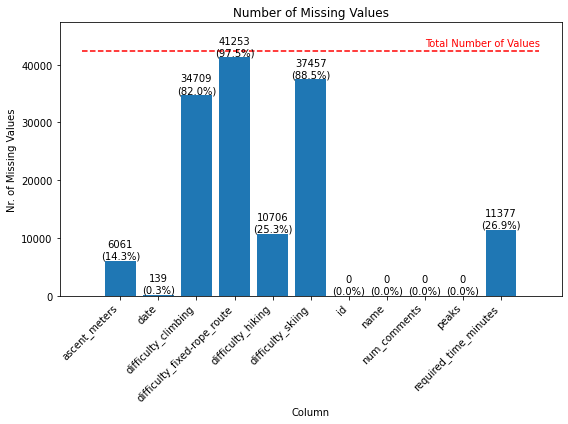

In [0]:
tours_df = spark.createDataFrame(
    parsedTours,
    samplingRatio=0.5
)

missing_values_count = tours_df.select(
    [count(when(col(c).isNull(), c)).alias(c)
     for c in tours_df.columns]
).toPandas().to_dict(orient="records")[0] # get first row

plot_na_values(missing_values_count, n_tours)

#### 3.1.2. Values for Categroical Features

In [0]:
def get_unique_dif(
    df: pyspark.sql.DataFrame,
    column: str,
) -> Dict[str, int]:
    """Get all unique values and their count from `column` in `df`.

    Parameters
    ----------
    df : pyspark.sql.DataFrame
        The DataFrame to extract the unique values from.
    column : str
        The column to extract the values from.

    Returns
    -------
    dict
        A dictionary with the difficulty as key and the counts
        as values.
    """
    return df \
        .select(column) \
        .groupBy(column) \
        .count() \
        .orderBy(column) \
        .toPandas().set_index(column) \
        .to_dict()["count"] # return column count

def plot_bar_unique_values(
    data: Dict[str, int],
    feature_name: str,
) -> None:
    """Plot the unique values as a bar plot. Missing values are not shown.

    Parameters
    ----------
    data : dict
        A dictionary with the unique value as keys and 
        their count as values. 
    feature_name : str
        The of the feature to which the values belong to. Is displayed
        in the title of the plot.
    """
    fig, ax = plt.subplots(figsize=(10, 4))
    sns.barplot(data, ax=ax)
    
    ax.set_title(f"Number of Tours with each Difficulty in {feature_name}")
    ax.set_xlabel("Difficulty")
    ax.set_ylabel("Nr. of Tours")
    fig.tight_layout()
    plt.xticks(rotation=45, ha='right')
    plt.show()


INFO:py4j.clientserver:Received command c on object id p0


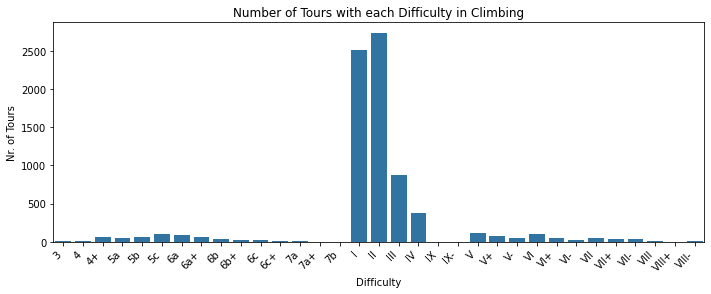

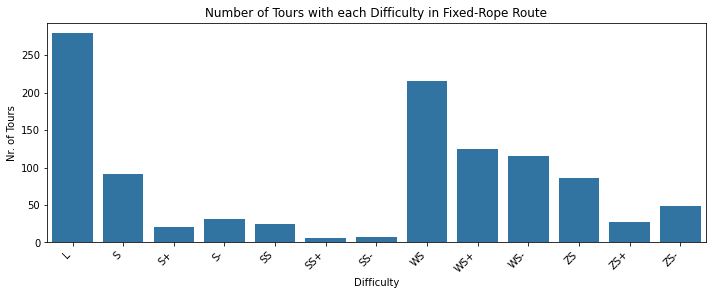

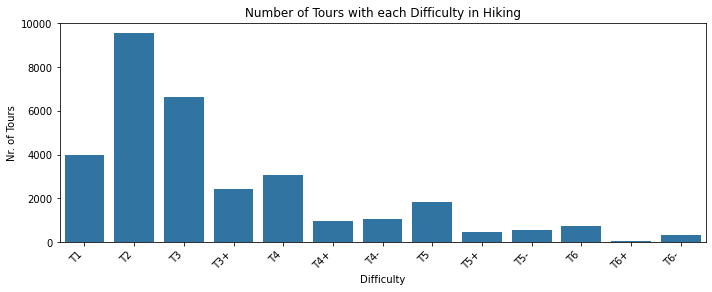

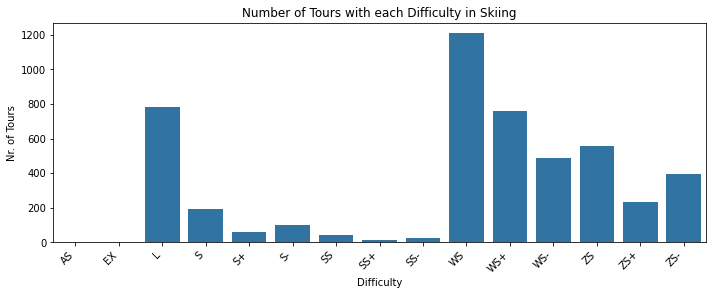

In [0]:

dif_cols = [c for c in tours_df.columns if "difficulty" in c]

for col in dif_cols:
    name_as_title = " ".join(col.split("_")[1:]).title()
    plot_bar_unique_values(
        get_unique_dif(tours_df, col),
        feature_name=name_as_title,
    )

#### 3.1.2. Log Analysis

While log analysis is a common use case for Elasticsearch, its integration would be out of scope for this assignment. Therefore, command-line tools and a Python script have been used instead. 

**The following code was run locally on Linux.** To this, the logfile was downloaded form Databicks. (Download location: `Compute` > `My Cluster` > `Driver Logs`)

To use the results of an earlier extraction for analysis, set the variable `EXTRACT` to `False`.

In [5]:
EXTRACT = False

if LOCAL and EXTRACT:
    log_file = "stderr_2025-06-02_3.log"

    !grep "time" {LOGS_DIR}/{log_file} > {LOGS_DIR}/time_errors.txt
    !grep "date" {LOGS_DIR}/{log_file} > {LOGS_DIR}/date_errors.txt
    !grep "peaks" {LOGS_DIR}/{log_file} > {LOGS_DIR}/peak_errors.txt
    !grep "ascent" {LOGS_DIR}/{log_file} > {LOGS_DIR}/ascent_errors.txt

In [7]:
def count_lines_with(search_term: str, filepath: Path) -> int:
    """Count all lines in ``filepath`` that contain the ``search_term``
    (case insensitive).

    Parameters
    ----------
    search_term : str
        The string to look for in each line of the file.
    filepath : `pathlib.Path`
        The Path object pointing to the file that should be analyzed.
    
    Returns
    -------
    int
        The number of lines that contain the `search_term`.
    """
    count = 0
    search_term_lower = search_term.lower()
    with open(filepath, "rt") as f:
        for line in f:
            if (search_term_lower in line.lower()):
                count += 1

    return count

def count_total_lines(filepath: Path) -> int:
    """Count the total number of files in file at ``filepath``."""
    with open(filepath, "rt") as f:
        return len(f.readlines())
    
def plot_bar_errors(
    data: Dict[str, int],
    feature_name: str,
    total_entires: int,
):
    """Plot a pie chart depicting how many values could not be parsed.
    
    Parameters
    ----------
    data : dict
        A dictionary with the description of the value as keys and 
        their count as values. 
    feature_name : str
        The of the feature to which the values belong to. Is displayed
        in the title of the plot.
    total_entries : int
        The total number of entries in the dataset.
    """
    data["Parsed Correctly"] = total_entires - sum(data.values())
    assert sum(data.values()) == total_entires, "values do not add up"

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.barplot(data, ax=ax)
    bars = ax.containers[0]
    ax.bar_label(
        bars,
        labels=[f"{x / total_entires * 100:.3f}%" for x in bars.datavalues],
        fontsize=10)
    
    ax.set_title(f"Status for all Values in {feature_name}")
    ax.set_xlabel("Status")
    ax.set_ylabel("Nr. of Values")
    fig.tight_layout()
    plt.show()

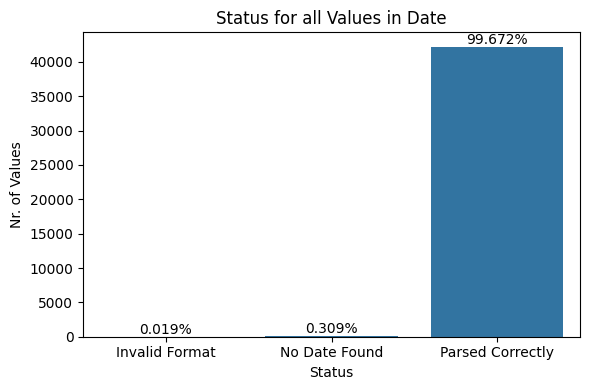

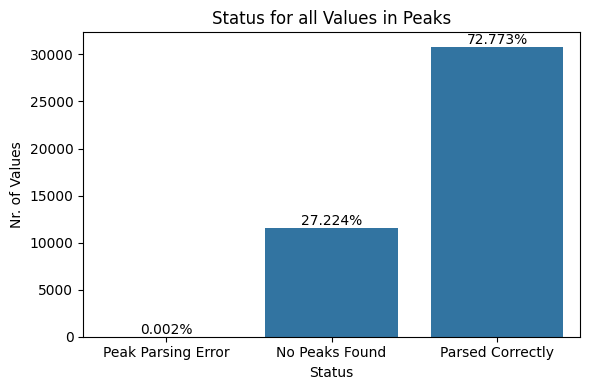

---Ascent---
Number of missing ascent values: 6061 (14.32%)
---Time---
Number of missing time values: 11377 (26.88%)


In [8]:
if LOCAL:
    n_tours = 42330

    # Date
    date_error_file = LOGS_DIR / "date_errors.txt"
    date_data = {}

    date_data["Invalid Format"] = count_lines_with(
        "Invalid Date Format",
        date_error_file,
    )
    date_data["No Date Found"] = count_lines_with(
        "No date found",
        date_error_file,
    )
    assert sum(date_data.values()) == count_total_lines(date_error_file), \
            "Some data logs have not been counted"
    plot_bar_errors(date_data, "Date", n_tours)

    # Peaks
    peak_error_file = LOGS_DIR / "peak_errors.txt"
    peak_data = {}
    peak_data["Peak Parsing Error"] = count_lines_with(
        "[<Selector",
        peak_error_file,
    )
    peak_data["No Peaks Found"] = count_lines_with(
        "no peaks found. original text: []",
        peak_error_file,
    )
    assert sum(peak_data.values()) == count_total_lines(peak_error_file), \
        "Some peak logs have not been counted"
    plot_bar_errors(peak_data, "Peaks", n_tours)
    
    # Ascent
    ascent_error_file = LOGS_DIR / "ascent_errors.txt"
    missing_ascent_values = count_lines_with(
        "Invalid ascent format encountered: []",
        ascent_error_file,
    )
    assert missing_ascent_values == count_total_lines(ascent_error_file), \
        "Some ascent logs have not been counted"

    print("---Ascent---")
    print(f"Number of missing ascent values: {missing_ascent_values} "
          f"({missing_ascent_values  / n_tours * 100:.2f}%)")
    
    # Time
    time_error_file = LOGS_DIR / "time_errors.txt"
    missing_time_values = count_lines_with(
        "No time found: []",
        time_error_file,
    )
    assert missing_time_values == count_total_lines(time_error_file), \
        "Some time logs have not been counted"

    print("---Time---")
    print(f"Number of missing time values: {missing_time_values} "
          f"({missing_time_values  / n_tours * 100:.2f}%)")

#### 3.1.3. Evaluation of Data Quality

Due to the Setup of the website which makes almost all fields optional, there are a lot of missing values.
The parsing of the actual data worked in almost all cases, however for some features, there were parsing errors:

| Feature | Examples for Erroneous Text | Occurrences |
| :--- | :--- | :--- |
| Date | `30 Mai 201` <br> `25 April 9` <br> `27 September 217` | 8 |
| Peaks | `Ferdinandea -8 m` | 1 (was fixed by changing the regular expression) |

Based on the Log Analysis no further parsing errors have been found. However, it should be noted, that the analysis has also not been performed for the difficulty features and the number of comments feature.

Furthermore, the difficulty features sometimes allow the use of multiple different scales, making it difficult to compare values or convert them to a single numerical scale, which would make comparisons easier.

Wenn counting comments, no distinction was made between top-level comments and replies to existing comments.  

## 3.2. Aggregation

The data is aggregated on a monthly basis to see the distribution of various features over time.

In [0]:
def get_month_nr(date: datetime) -> str:
    """Gets the month number from ``date``.""

    Parameters
    ----------
    date : datetime
        The date to get the month number form.

    Returns
    -------
    The number of the month. Range: (1-12) 
    """
    return date.month

def get_month_name(date: datetime) -> str:
    """Gets the name of the month from ``date``.""

    Parameters
    ----------
    date : datetime
        The date to get the month name  form.

    Returns
    -------
    The entire name of the month in ``date``. 
    """
    return date.strftime("%B")

# Convert the python functions to a PySpark UDF
get_month_nr_udf = udf(get_month_nr, IntegerType())
get_month_name_udf = udf(get_month_name, StringType())


tours_df_no_na_dates_df = tours_df.dropna(subset=["date"])

tours_with_month_col_df = tours_df_no_na_dates_df.withColumn(
    "month_name",
    get_month_name_udf(tours_df.date)
)
tours_with_month_col_df = tours_with_month_col_df.withColumn(
    "month_nr",
    get_month_nr_udf(tours_df.date)
)

tours_per_month_df = tours_with_month_col_df \
    .groupBy("month_name", "month_nr") \
    .agg({"*": "count",
          "required_time_minutes": "avg",
          "ascent_meters": "avg",
          "num_comments": "avg",
          })
    

tours_per_month_df = tours_per_month_df \
    .withColumnRenamed("count(1)", 'num_tours') \
    .orderBy("month_nr", ascending=True)
tours_per_month_df.show()

+----------+--------+------------------+---------+--------------------------+------------------+
|month_name|month_nr| avg(num_comments)|num_tours|avg(required_time_minutes)|avg(ascent_meters)|
+----------+--------+------------------+---------+--------------------------+------------------+
|   January|       1|2.0423546302943287|     2786|         525.3366649132035| 896.1174510620575|
|  February|       2|1.7061503416856492|     2634|         538.2037779049799| 963.7935168738899|
|     March|       3|2.0964434476129448|     3121|         606.6366604477612| 971.9241583425824|
|     April|       4|1.9568685376661743|     3385|         623.1978955888304| 951.4208534067446|
|       May|       5|  1.82680934947902|     3551|         569.6682152535811|  969.542345276873|
|      June|       6|2.0816016218955906|     3946|         714.4388757196072|1101.2788952266587|
|      July|       7|1.8921362489486964|     4756|         940.7122222222222|  1211.84742014742|
|    August|       8|1.9507056

In [0]:
def plot_agg_per_month(
    df: pyspark.sql.DataFrame,
    feature: str,
    ylabel: str,
    title: str,
) -> None:
    """Plot a ``feature`` aggregated per month.
    
    Parameters
    ----------
    df : pyspark.sql.DataFrame
        The aggregated DataFrame to get the values from.
    feature : str
        The name of the Feature to plot.
    ylabel : str
        The label for the Y axis.
    title : str
        The title of the plot.
    """
    pd_df = df.toPandas()
    pd_df.set_index("month_name", inplace=True)

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.barplot(pd_df, x="month_name", y=feature, ax=ax)
    
    ax.set_title(title)
    ax.set_xlabel("Month")
    ax.set_ylabel(ylabel)
    fig.tight_layout()
    plt.xticks(rotation=45, ha='right')
    plt.show()

INFO:py4j.clientserver:Received command c on object id p0
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


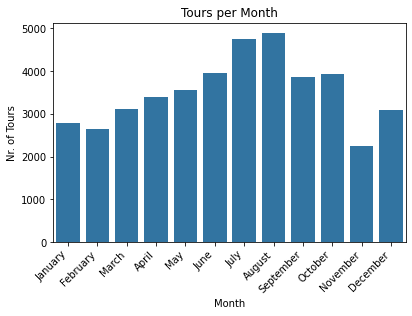

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


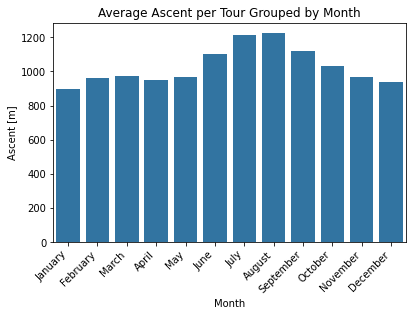

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


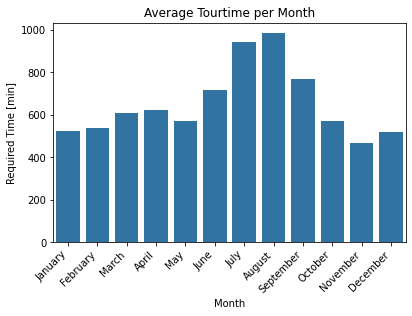

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


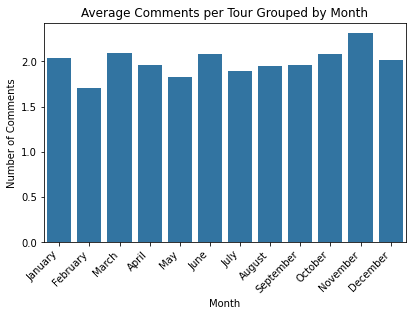

In [0]:
agg_features = [
    {
        "feature": "num_tours",
        "ylabel": "Nr. of Tours",
        "title": "Tours per Month"
    },
    {
        "feature": "avg(ascent_meters)",
        "ylabel": "Ascent [m]",
        "title": "Average Ascent per Tour Grouped by Month",
    },
    {
        "feature": "avg(required_time_minutes)",
        "ylabel": "Required Time [min]",
        "title": "Average Tourtime per Month",
    },
    {
        "feature": "avg(num_comments)",
        "ylabel": "Number of Comments",
        "title": "Average Comments per Tour Grouped by Month",
    }
]


for f in agg_features:
    plot_agg_per_month(tours_per_month_df, **f)